In [47]:
import yfinance as yf

sbux = yf.Ticker("SBUX")
sbux_hist = sbux.history(period="max")

In [50]:
import os
import pandas as pd

DATA_PATH = "sbux_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        sbux_hist = pd.read_json(DATA_PATH)
else:
    sbux = yf.Ticker("SBUX")
    sbux_hist = sbux.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    SBUX_hist.to_json(DATA_PATH)

In [51]:
sbux_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1992-06-26,0.266556,0.282422,0.260210,0.272903,224358400,0.0,0
1992-06-29,0.276076,0.298289,0.269729,0.291942,58732800,0.0,0
1992-06-30,0.298289,0.301462,0.279249,0.282422,34777600,0.0,0
1992-07-01,0.285596,0.291942,0.276076,0.288769,18316800,0.0,0
1992-07-02,0.291942,0.291942,0.282422,0.288769,13996800,0.0,0


<AxesSubplot:>

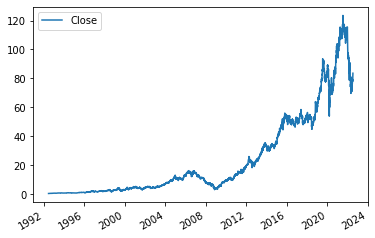

In [52]:
# Visualize microsoft stock prices
sbux_hist.plot.line(y="Close", use_index=True)

In [53]:
# Ensure we know the actual closing price
data = sbux_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = sbux_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [54]:
data.head()

,Actual_Close,Target
1992-06-26,0.272903,NaN
1992-06-29,0.291942,1.0
1992-06-30,0.282422,0.0
1992-07-01,0.288769,1.0
1992-07-02,0.288769,0.0


In [55]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
sbux_prev = sbux_hist.copy()
sbux_prev = sbux_prev.shift(1)

In [56]:
sbux_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1992-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-06-29,0.266556,0.282422,0.260210,0.272903,224358400.0,0.0,0.0
1992-06-30,0.276076,0.298289,0.269729,0.291942,58732800.0,0.0,0.0
1992-07-01,0.298289,0.301462,0.279249,0.282422,34777600.0,0.0,0.0
1992-07-02,0.285596,0.291942,0.276076,0.288769,18316800.0,0.0,0.0


In [57]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(sbux_prev[predictors]).iloc[1:]

In [58]:
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
1992-06-29,0.291942,1.0,0.272903,224358400.0,0.266556,0.282422,0.260210
1992-06-30,0.282422,0.0,0.291942,58732800.0,0.276076,0.298289,0.269729
1992-07-01,0.288769,1.0,0.282422,34777600.0,0.298289,0.301462,0.279249
1992-07-02,0.288769,0.0,0.288769,18316800.0,0.285596,0.291942,0.276076
1992-07-06,0.288769,0.0,0.288769,13996800.0,0.291942,0.291942,0.282422


In [59]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

In [60]:
# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [61]:
from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.6166666666666667

<AxesSubplot:>

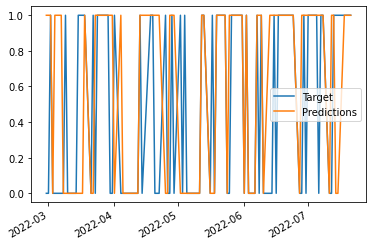

In [62]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

In [63]:
i = 1000
step = 750

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])

In [64]:
preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds<=.6] = 0

In [65]:
preds.head()

1996-06-12    0.0
1996-06-13    0.0
1996-06-14    0.0
1996-06-17    0.0
1996-06-18    0.0
dtype: float64

In [66]:
predictions = []
# Loop over the dataset in increments
for i in range(1000, data.shape[0], step):
    # Split into train and test sets
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    # Fit the random forest model
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict_proba(test[predictors])[:,1]
    preds = pd.Series(preds, index=test.index)
    preds[preds > .6] = 1
    preds[preds<=.6] = 0

    # Combine predictions and test values
    combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

    predictions.append(combined)

In [67]:
predictions[0].head()

,Target,Predictions
1996-06-12,0.0,0.0
1996-06-13,0.0,0.0
1996-06-14,0.0,0.0
1996-06-17,0.0,0.0
1996-06-18,1.0,0.0


In [68]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

In [69]:
predictions = backtest(data, model, predictors)

In [70]:
predictions["Predictions"].value_counts()

0.0    6511
1.0      61
Name: Predictions, dtype: int64

In [71]:
predictions["Target"].value_counts()

1.0    3288
0.0    3284
Name: Target, dtype: int64

In [72]:
precision_score(predictions["Target"], predictions["Predictions"])

0.4262295081967213

In [73]:
weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

In [74]:
weekly_trend = data.shift(1).rolling(7).sum()["Target"]

In [75]:
data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

In [76]:
data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

In [77]:
data["weekly_trend"] = weekly_trend

In [78]:
data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [79]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]

In [80]:
predictions = backtest(data.iloc[365:], model, full_predictors)

In [81]:
precision_score(predictions["Target"], predictions["Predictions"])

0.512

In [82]:
# Show how many trades we would make

predictions["Predictions"].value_counts()

0.0    5457
1.0     750
Name: Predictions, dtype: int64

<AxesSubplot:xlabel='Date'>

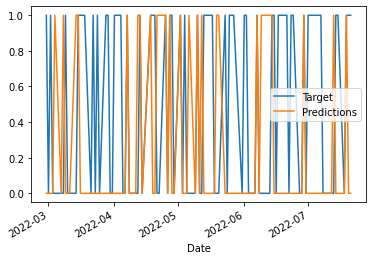

In [36]:
# Look at trades we would have made in the last 100 days

predictions.iloc[-100:].plot()